# Предсказание коэффициента восстановления золота из руды

## Описание

**Задача:**

Подготовить прототип модели машинного обучения для компании «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Описание данных:**

* Технологический процесс

  * `Rougher feed` — исходное сырье
  
  * `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  
    * `Xanthate` — ксантогенат (промотер, или активатор флотации)
    
    * `Sulphate` — сульфат (на данном производстве сульфид натрия)
    
    * `Depressant` — депрессант (силикат натрия)
    
  * `Rougher process` — флотация
  
  * `Rougher tails` — отвальные хвосты
  
  * `Float banks` — флотационная установка
  
  * `Cleaner process` — очистка
  
  * `Rougher Au` — черновой концентрат золота
  
  * `Final Au` — финальный концентрат золота
  
* Параметры этапов

  * `air amount` — объём воздуха
  
  * `fluid levels` — уровень жидкости
  
  * `feed size` — размер гранул сырья
  
  * `feed rate` — скорость подачи

**Наименование признаков:**

[этап].[тип_параметра].[название_параметра]

* Возможные значения для блока [этап]:

  * `rougher` — флотация
  
  * `primary_cleaner` — первичная очистка
  
  * `secondary_cleaner` — вторичная очистка

  * `final` — финальные характеристики

* Возможные значения для блока [тип_параметра]:

  * `input` — параметры сырья

  * `output` — параметры продукта
  
  * `state` — параметры, характеризующие текущее состояние этапа

  * `calculation` — расчётные характеристики

**Метрика качества:** sMAPE

## Импорт библиотек, загрузка данных и изучение общей информации о них

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

%matplotlib inline

In [2]:
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')
data_full = pd.read_csv('gold_recovery_full_new.csv')

In [3]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [7]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


1) Все признаки, кроме времени, количественные

2) В данных довольно много пропусков

Чтобы при работе с моделями машинного обучения в итоговом тестировании проверить модели на тестовой выборке, добавим в тестовый датасет правильные ответы, то есть колонки `rougher.output.recovery`, `final.output.recovery`

In [9]:
data_test['rougher.output.recovery'] = data_test['date'].apply(
    lambda x: float(data_full.loc[data_full['date'] == x, 'rougher.output.recovery'])
)
data_test['final.output.recovery'] = data_test['date'].apply(
    lambda x: float(data_full.loc[data_full['date'] == x, 'final.output.recovery'])
)

## Подготовка данных

### Проверка корректности вычисления эффективности обогащения

Эффективность обогащения рассчитывается по формуле: $$Recovery = \frac{C(F - T)}{F(C - T)}$$
где:
* C — доля золота в концентрате после флотации/очистки
* F — доля золота в сырье/концентрате до флотации/очистки
* T — доля золота в отвальных хвостах после флотации/очистки

In [10]:
rough_recovery = data_train['rougher.output.recovery']

C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']
calculated_rough_recovery = C * (F - T) / (F * (C - T)) * 100

mean_absolute_error(rough_recovery, calculated_rough_recovery)

9.73512347450521e-15

Средняя абсолютная ошибка очень близка к нулю, следовательно, можно считать, что эффективность обогащения рассчитана верно

### Анализ признаков, недоступных в тестовой выборке

Необходимо заметить, что в тестовой выборке признаков сравнительно меньше, чем в обучающей (53 против 87). Посмотрим, какие признаки, присутствующие в тренировочной выборке, отсутствуют в тестовой. Для этого воспользуемся операцией разности множеств:

In [11]:
train_cols = set(data_train.columns)
test_cols = set(data_test.columns)

diff_set = sorted(list(train_cols.difference(test_cols)))
for col in diff_set:
    print(col)

final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_au
secondary_cleaner.output.tail_pb
secondary_cleaner.output.tail_s

Видно, что в основном отсутствующие в тренировочной выборке колонки - это параметры продукта, то есть того, что мы получаем на выходе каждого этапа. Также в тестовой выборке отсутствуют следующие колонки, относящиеся к рассчетам: 
`rougher.calculation.au_pb_ratio`,
`rougher.calculation.floatbank10_sulfate_to_au_feed`,
`rougher.calculation.floatbank11_sulfate_to_au_feed`,
`rougher.calculation.sulfate_to_au_concentrate`. Удалим из обучающей выборки все столбцы, которые отсутствуют в тренировочной, потому что информации для их рассчета у нас нет (это мы сделаем после проведения исследовательского анализа).

### Предобработка данных

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [13]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Колонку `date` переведем в тип datetime. Также заметим, что в тестовых данных время снималось в 59 минут 59 секунд каждого часа, а в тренировочных - в 0 минут 0 секунд. Округлим дату.

In [14]:
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')

In [15]:
data_train['date'] = data_train['date'].dt.round('1H')
data_test['date'] = data_test['date'].dt.round('1H')

Обработаем явные дубликаты

In [16]:
data_train.duplicated().unique(), data_test.duplicated().unique()

(array([False]), array([False]))

In [17]:
data_train['date'].duplicated().unique(), data_test['date'].duplicated().unique()

(array([False]), array([False]))

Таких нет. Данных за одно и то же время тоже нет.

Теперь займемся пропусками. К сожалению, они есть практически во всех колонках тренировочной выборки... Однако их количество в каждой колонке не превышает нескольких процентов, более того чаще всего их доля составляет несколько сотых процента. Поскольку колонок очень много, а данные терять не хочется, заменим все пропуски на медианные значения в соответствующих колонках (все медианы будем считать по обучающему набору)

In [18]:
cols_dict = {col : data_train[col].median() for col in data_train.columns if col != 'date'}
for col in data_train.columns:
    if col == 'date':
        continue
    data_train[col] = data_train[col].fillna(cols_dict[col])
    try:
        data_test[col] = data_test[col].fillna(cols_dict[col])
    except:
        continue

In [19]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14149 non-null  float64       
 2   final.output.concentrate_pb                         14149 non-null  float64       
 3   final.output.concentrate_sol                        14149 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14149 non-null  float64       
 8   final.

In [20]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5290 non-null   float64       
 2   primary_cleaner.input.depressant            5290 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5290 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

На этом предобработка завершена. Можем приступать к исследовательскому анализу

## Исследовательский анализ

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Посмотрим на исходное сырье

In [21]:
[col for col in data_train.columns if 'feed_ag' in col or 'feed_au' in col or 'feed_pb' in col]

['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']

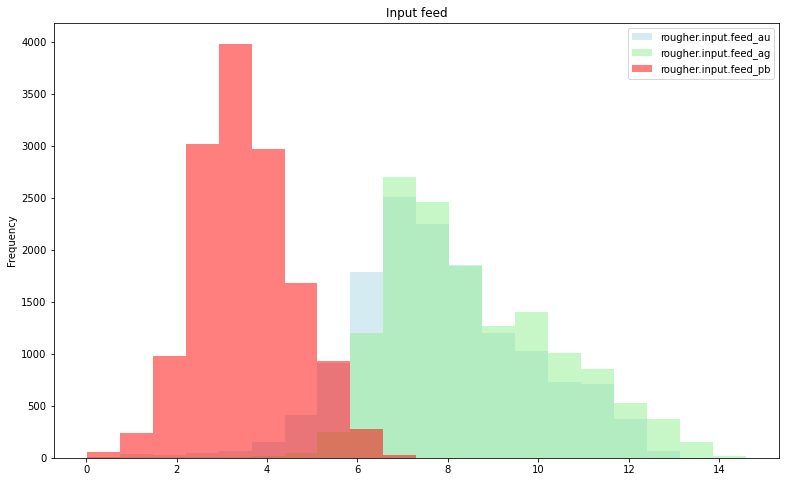

       rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb
count           14149.000000           14149.000000           14149.000000
mean                7.866577               8.579195               3.522071
std                 1.919506               1.896284               1.069626
min                 0.010000               0.010000               0.010000
25%                 6.596217               7.132802               2.784928
50%                 7.649138               8.156092               3.422677
75%                 9.066976               9.918304               4.220115
max                13.126043              14.596026               7.142594


In [22]:
col_list = []
for me in ['au', 'ag', 'pb']:
    # Создаем список колонок
    col_list.append('rougher.input.feed_' + me)

# Строим график
data_train[col_list].plot(
    kind='hist',
    bins=20,
    figsize=(13, 8),
    legend=True,
    alpha=0.5,
    color=['lightblue', 'lightgreen', 'red'],
    title='Input feed'
)
plt.show()

# Выводим описательные статистики
print(data_train[col_list].describe())

Из графика видно, что в сырье, поступающем на флотацию, меньше всего свинца, а вот золота и серебра примерно одинаково (медианные значения: 3.4 - свинец, 8.2 - серебро и 7.6 - золото). Распределения концентрации золота и серебра очень похожи, что также говорит о том, что в исходном сырье обычно они играют примерно одинаковую роль по концентрации

А теперь изучим изменение концентрации металлов на разных этапах

In [23]:
# Список интересующих нас колонок
[col for col in data_train.columns if 'concentrate_ag' in col or 'concentrate_au' in col or 'concentrate_pb' in col]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

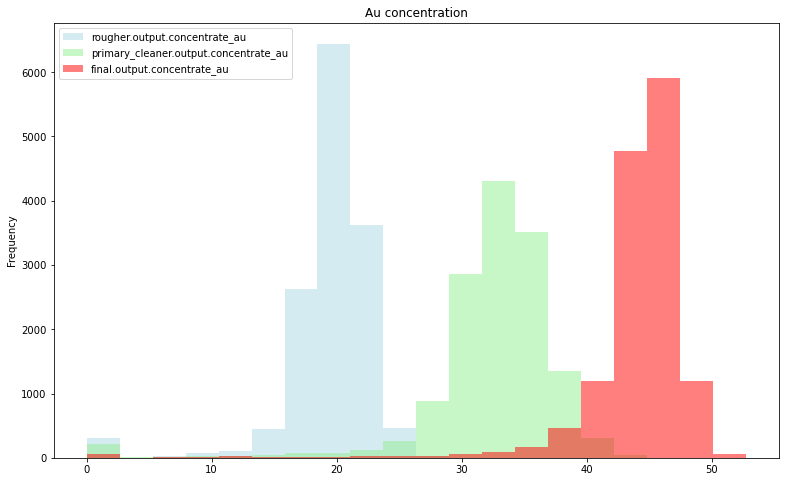

       rougher.output.concentrate_au  primary_cleaner.output.concentrate_au  \
count                   14149.000000                           14149.000000   
mean                       19.439958                              32.386836   
std                         3.765192                               5.798843   
min                         0.000000                               0.000000   
25%                        18.432161                              30.857764   
50%                        19.947312                              33.225835   
75%                        21.392714                              35.330145   
max                        28.146838                              45.933934   

       final.output.concentrate_au  
count                 14149.000000  
mean                     44.003792  
std                       4.905261  
min                       0.000000  
25%                      43.276111  
50%                      44.872436  
75%                      46.1

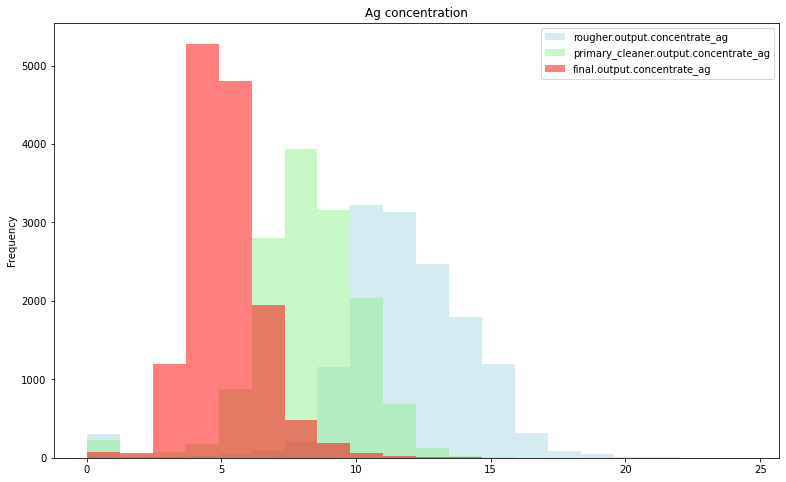

       rougher.output.concentrate_ag  primary_cleaner.output.concentrate_ag  \
count                   14149.000000                           14149.000000   
mean                       11.775812                               8.200916   
std                         2.731747                               2.005185   
min                         0.000000                               0.000000   
25%                        10.486871                               7.107126   
50%                        11.747362                               8.226247   
75%                        13.426419                               9.504924   
max                        24.480271                              16.081632   

       final.output.concentrate_ag  
count                 14149.000000  
mean                      5.142023  
std                       1.369538  
min                       0.000000  
25%                       4.211660  
50%                       4.994652  
75%                       5.8

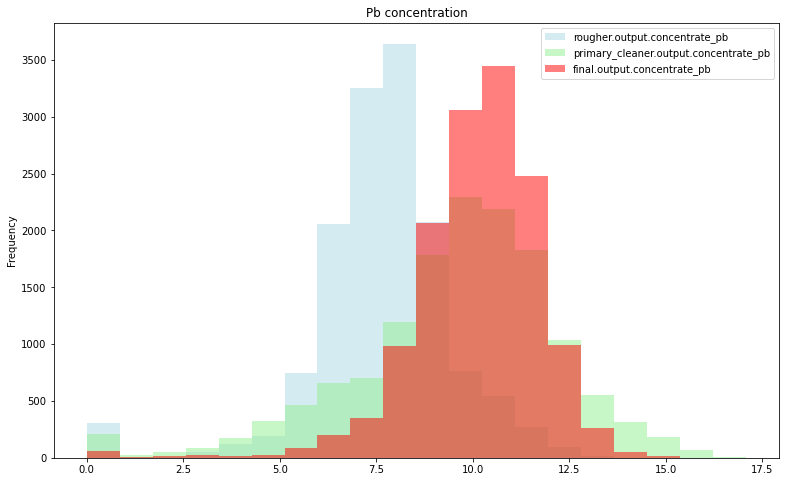

       rougher.output.concentrate_pb  primary_cleaner.output.concentrate_pb  \
count                   14149.000000                           14149.000000   
mean                        7.664555                               9.590957   
std                         1.856279                               2.686229   
min                         0.000000                               0.000000   
25%                         6.850501                               8.345274   
50%                         7.760435                               9.933520   
75%                         8.601927                              11.296639   
max                        13.617072                              17.081278   

       final.output.concentrate_pb  
count                 14149.000000  
mean                     10.132971  
std                       1.654872  
min                       0.000000  
25%                       9.297528  
50%                      10.297144  
75%                      11.1

In [24]:
for me in ['au', 'ag', 'pb']:
    # Создаем список колонок
    col_list = [
        'rougher.output.concentrate_' + me,
        'primary_cleaner.output.concentrate_' + me,
        'final.output.concentrate_' + me
    ]
    
    # Строим график
    data_train[col_list].plot(
        kind='hist',
        bins=20,
        figsize=(13, 8),
        legend=True,
        alpha=0.5,
        color=['lightblue', 'lightgreen', 'red'],
        title=me.capitalize() + ' concentration'
    )
    plt.show()
    
    # Выводим описательные статистики
    print(data_train[col_list].describe())

* Все распределения имеют разную форму. Кроме того, у свинца медиана практически не меняется после проведения первой очистки (примерно 9.5%), у серебра при приближении к завершению техпроцесса она уменьшается примерно от 11% до 5%, а у золота - увеличивается примерно от 19% до 44% (у золота она и должна увеличиваться, так как мы его пытаемся извлечь из руды). Среднее ведет себя примерно таким же образом.

* У всех металлов минимальная концентрация - 0%, причем, судя по графикам, таких значений довольно много - несколько сотен на каждом этапе у каждого металла.

* Максимальная концентрация больше медианного значения примерно на 10% у каждого металла.

Посмотрим также, как меняется концентрация соответствующих металлов в отвальных хвостах

In [25]:
# Список интересующих нас колонок
[col for col in data_train.columns if 'tail_ag' in col or 'tail_au' in col or 'tail_pb' in col]

['final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au']

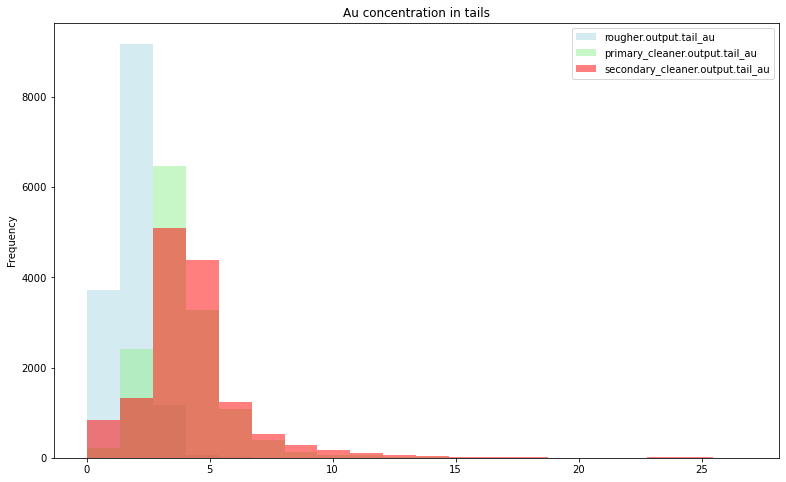

       rougher.output.tail_au  primary_cleaner.output.tail_au  \
count            14149.000000                    14149.000000   
mean                 1.757473                        3.839637   
std                  0.713187                        1.603544   
min                  0.020676                        0.000000   
25%                  1.310800                        2.867957   
50%                  1.745513                        3.510337   
75%                  2.186790                        4.492470   
max                  9.688980                       17.788925   

       secondary_cleaner.output.tail_au  
count                      14149.000000  
mean                           4.246961  
std                            2.389060  
min                            0.000000  
25%                            3.153122  
50%                            3.980210  
75%                            4.883943  
max                           26.811643  


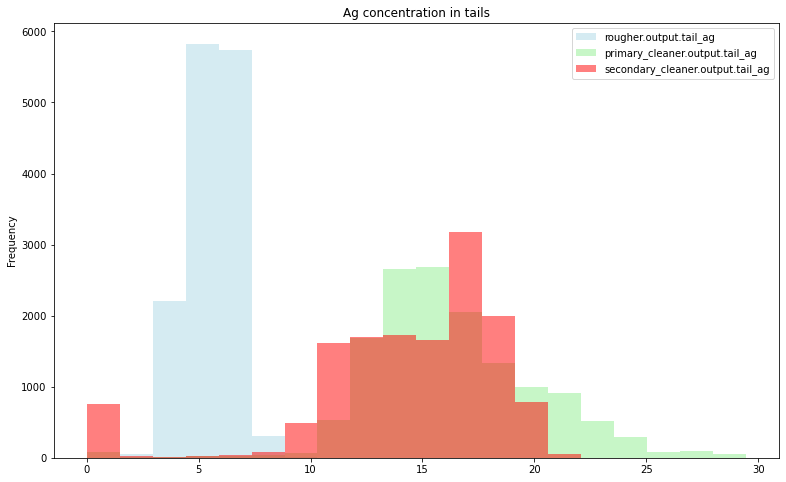

       rougher.output.tail_ag  primary_cleaner.output.tail_ag  \
count            14149.000000                    14149.000000   
mean                 5.567135                       16.303894   
std                  1.039100                        3.739714   
min                  0.594562                        0.000000   
25%                  4.921773                       13.873202   
50%                  5.722018                       15.800604   
75%                  6.310598                       18.450107   
max                 12.719177                       29.459575   

       secondary_cleaner.output.tail_ag  
count                      14149.000000  
mean                          14.281781  
std                            4.476828  
min                            0.000000  
25%                           12.177541  
50%                           15.357951  
75%                           17.230072  
max                           23.264738  


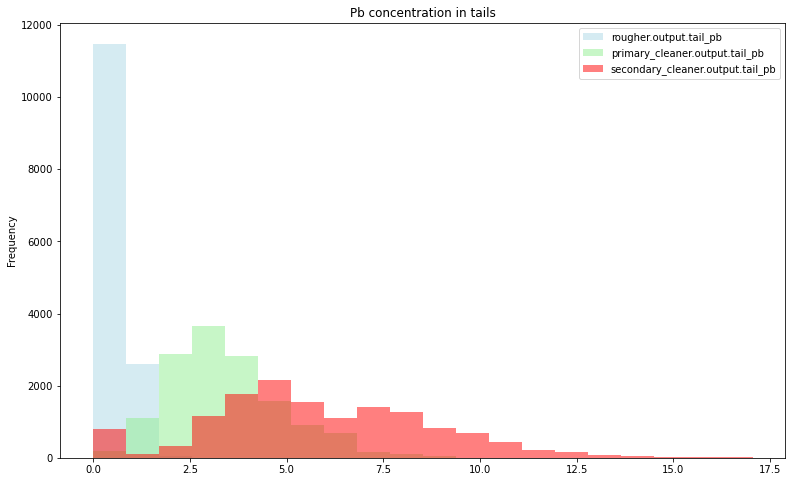

       rougher.output.tail_pb  primary_cleaner.output.tail_pb  \
count            14149.000000                    14149.000000   
mean                 0.653277                        3.443159   
std                  0.263766                        1.489334   
min                  0.007566                        0.000000   
25%                  0.474047                        2.421481   
50%                  0.625805                        3.218374   
75%                  0.794326                        4.250882   
max                  3.778064                        9.634565   

       secondary_cleaner.output.tail_pb  
count                      14149.000000  
mean                           5.848576  
std                            2.860808  
min                            0.000000  
25%                            3.983029  
50%                            5.442310  
75%                            7.797396  
max                           17.042505  


In [26]:
for me in ['au', 'ag', 'pb']:
    # Создаем список колонок
    col_list = [
        'rougher.output.tail_' + me,
        'primary_cleaner.output.tail_' + me,
        'secondary_cleaner.output.tail_' + me
    ]
    
    # Строим график
    data_train[col_list].plot(
        kind='hist',
        bins=20,
        figsize=(13, 8),
        legend=True,
        alpha=0.5,
        color=['lightblue', 'lightgreen', 'red'],
        title=me.capitalize() + ' concentration in tails'
    )
    plt.show()
    
    # Выводим описательные статистики
    print(data_train[col_list].describe())

Видно, что чем ближе к концу процесса, тем выше среднее  и медиана, хотя медиана растет медленнее среднего. Также следует заметить, что при приближении к концу процесса распределения становятся все более пологими, тогда как в начале они были оченнь узкими и сконцентрированными близко к медианному значению

Разберемся с выбросами. Опишем методику, по которой будем действовать. Пусть $\mu$ - среднее, $\sigma$ - стандартное отклонение. Тогда в интервал $(\mu - 3\sigma, \mu + 3\sigma)$ в среднем попадает 99,7% всех значений признака. Таким образом, все значения, не попавшие в этот интервал, будем считать выбросами. У нас есть три этапа обработки сырья, на каждом этапе мы рассматриваем концентрацию трех металлов (Au, Ag, Pb), к каждому из 9 получившихся случаев применим описанный только что метод избавления от выбросов

In [27]:
for me in ['au', 'ag', 'pb']:
    # Список колонок
    col_list = [
        'rougher.output.concentrate_' + me,
        'primary_cleaner.output.concentrate_' + me,
        'final.output.concentrate_' + me
    ]
    
    # Считаем средние и стандартные отклонения для каждой колонки на обучающей выборке
    avgs = [data_train[col].mean() for col in col_list]
    stds = [data_train[col].std() for col in col_list]
    
    # Убираем выбросы
    for i in range(3):
        col = col_list[i]
        m = avgs[i]
        s = stds[i]
        data_train = data_train.loc[(m - 3 * s <= data_train[col]) & (data_train[col] <= m + 3 * s)]

In [28]:
data_train.shape

(12805, 87)

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

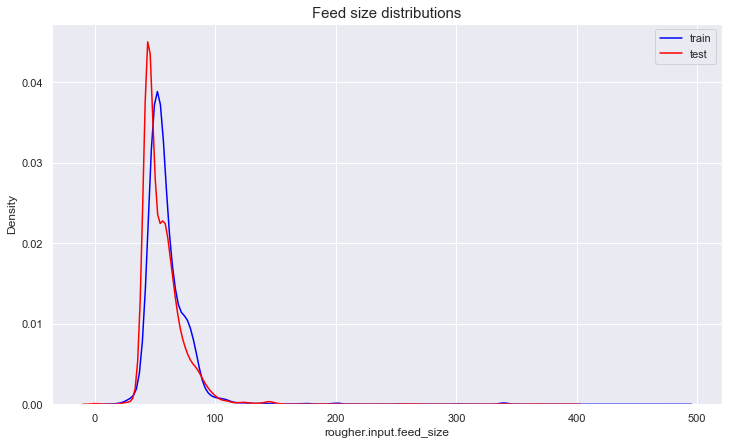

In [29]:
sns.set(rc={"figure.figsize" : (12, 7), 'axes.titlesize' : 15})

sns.kdeplot(data=data_train, x='rougher.input.feed_size', color='blue').set_title('Feed size distributions')
sns.kdeplot(data=data_test, x='rougher.input.feed_size', color='red').set_title('Feed size distributions')

plt.legend(['train', 'test'])
plt.show()

In [30]:
data_train['rougher.input.feed_size'].describe()

count    12805.000000
mean        60.064967
std         22.546700
min          9.659576
25%         49.134017
50%         55.373885
75%         65.708066
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [31]:
data_test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.950988
std        19.079955
min         0.046369
25%        43.906504
50%        50.846843
75%        62.425276
max       392.494040
Name: rougher.input.feed_size, dtype: float64

Проанализировав графики и описательные статистики, делаем вывод, что распределения примерно одинаковы

### Исследование суммарной концентрации всех веществ на разных стадиях

In [32]:
# Список интересующих нас колонок
[col for col in data_train.columns if 'concentrate_' in col or 'feed_au' in col or 'feed_ag' in col or 'feed_pb' in col or 'feed_sol' in col]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [33]:
for step in ['input', 'rougher', 'primary_cleaner', 'final']:
    data_train[step] = np.zeros(data_train.shape[0])
    for sub in ['au', 'ag', 'sol', 'pb']:
        if step == 'input':
            data_train[step] += data_train['rougher.input.feed_' + sub]
        else:
            data_train[step] += data_train[step + '.output.concentrate_' + sub]

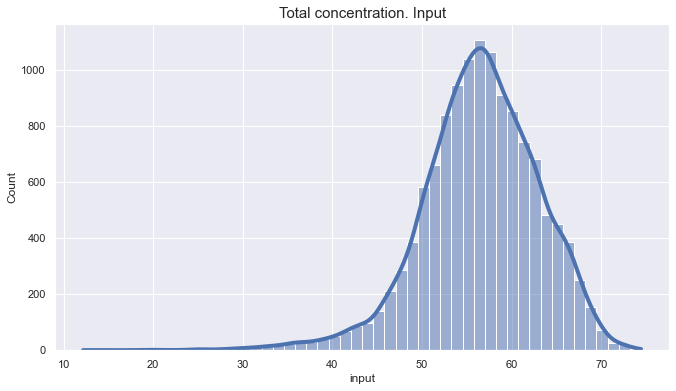

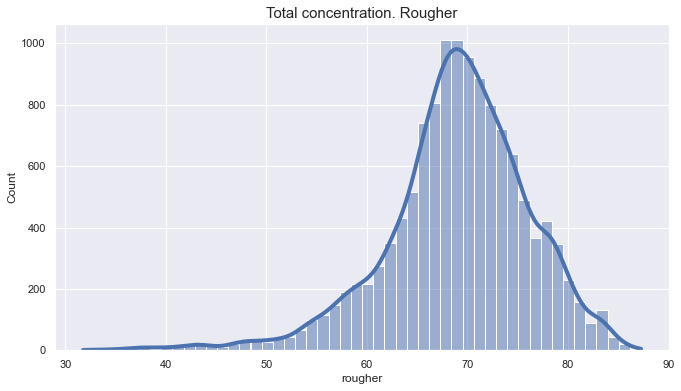

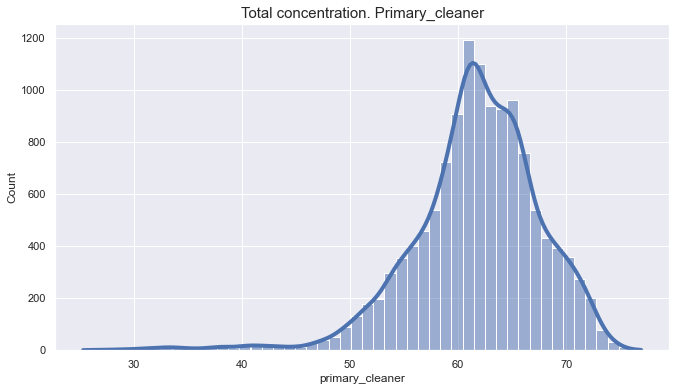

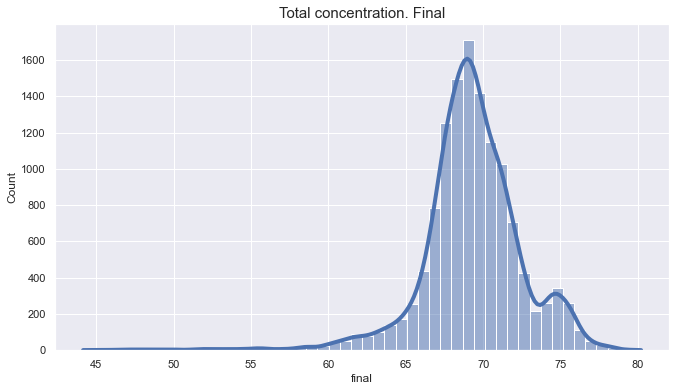

              input       rougher  primary_cleaner         final
count  12805.000000  12805.000000     12805.000000  12805.000000
mean      56.518137     69.014663        61.673682     69.275617
std        6.503653      7.112529         5.969101      3.283270
min       12.181885     31.752237        25.332518     44.147520
25%       52.731911     65.473080        58.720557     67.768262
50%       56.698033     69.384457        61.994528     69.240917
75%       60.897389     73.534002        65.438279     71.016968
max       74.458253     87.273435        76.918076     80.210644


In [34]:
# Создаем список колонок
col_list = ['input', 'rougher', 'primary_cleaner', 'final']

# Строим графики
for col in col_list:
    sns.set(rc={"figure.figsize" : (11, 6), 'axes.titlesize' : 15})
    sns.histplot(
        data=data_train,
        x=col,
        bins=50,
        kde=True,
        line_kws={'linewidth' : 4}
    ).set_title('Total concentration. ' + col.capitalize())

    plt.show()

# Выводим описательные статистики
print(data_train[col_list].describe())

Из полученных графиков и описательных статистик можно сделать следующие выводы:

* Средние и медианные значения концентрации после флотации и вторичной очистки примерно равны между собой, а их стандартные отклонения отличаются примерно в 2 раза. Что касается концентрации после первичной очистки, среднее и медиана здесь меньше, чем после флотации и вторичной очистки, а вот стандартное отклонение примерно посередине. В исходном сырье медиана самая маленькая, что неудивительно, так как это сырье еще не очищено от примесей, а вот стандартное отклонение побольше, чем после первичной очистки, то есть разброс данных здесь немного больше.

* Видно, что при приближении к концу техпроцесса распределение концентрации становится более узким, то есть разброс значений становится меньше, это говорит о том, что вероятность получить большие отклонения от среднего (и медианны) снижается, а значит, концентрация исследуемых веществ в среднем растет

In [35]:
data_train['year'] = data_train['date'].apply(lambda x: x.year)
data_train['month'] = data_train['date'].apply(lambda x: x.month)
data_train['day'] = data_train['date'].apply(lambda x: x.day)
data_train['hour'] = data_train['date'].apply(lambda x: x.hour)

data_test['year'] = data_test['date'].apply(lambda x: x.year)
data_test['month'] = data_test['date'].apply(lambda x: x.month)
data_test['day'] = data_test['date'].apply(lambda x: x.day)
data_test['hour'] = data_test['date'].apply(lambda x: x.hour)

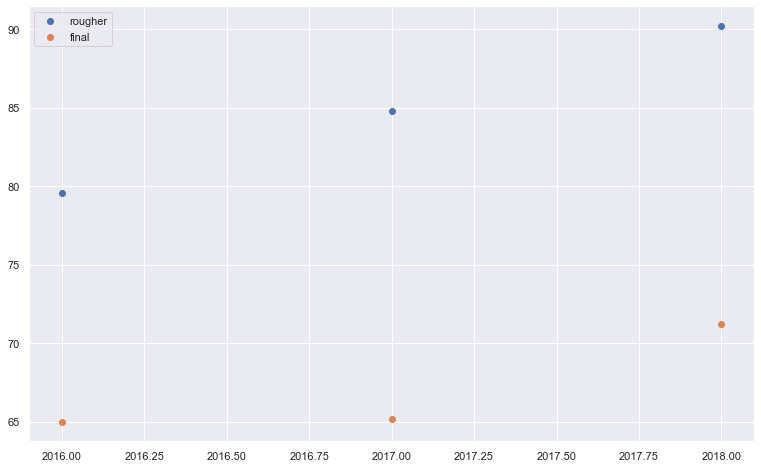

In [36]:
fig, ax = plt.subplots()

for step in ['rougher', 'final']:
    x, y = [], []
    for year in range(2016, 2019):
        x.append(year)
        y.append(data_train.loc[data_train['year'] == year, step + '.output.recovery'].mean())
    
    ax.scatter(x, y, label=step)
    ax.legend()

fig.set_figwidth(13)
fig.set_figheight(8)

plt.show()

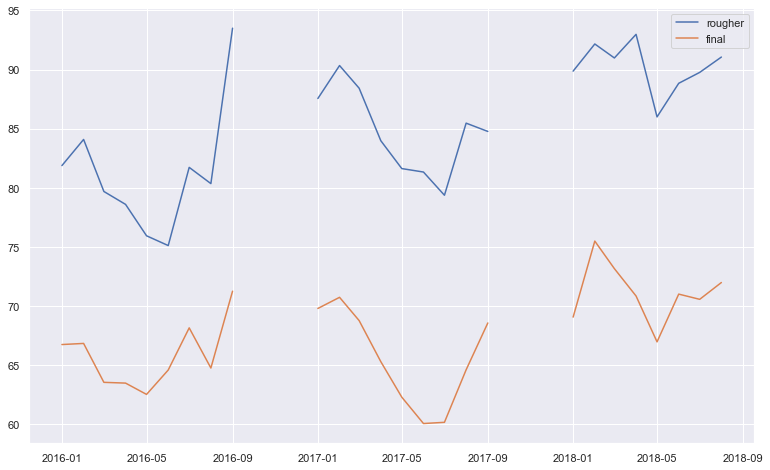

In [37]:
fig, ax = plt.subplots()

for step in ['rougher', 'final']:
    x, y = [], []
    for year in range(2016, 2019):
        for month in range(1, 13):
            x.append(pd.to_datetime(str(year) + '-' + str(month), format='%Y-%m'))
            y.append(data_train.query("(year == @year) & (month == @month)")[step + '.output.recovery'].mean())
    
    ax.plot(x, y, label=step)
    ax.legend()

fig.set_figwidth(13)
fig.set_figheight(8)

plt.show()

По этим графикам ясно видно, что в данных присутствует временная зависимость. Поэтому колонку с датой удалять не хотелось бы, однако не все модели способны с ней работать, в связи с этим эту колонку удалим, а вместо нее создадим 4 колонки: год, месяц, день, час.

### Вывод

* Концентрация металлов (Au, Ag, Pb)

  * У свинца медиана практически не меняется после проведения первой очистки (примерно 9.5%), у серебра при приближении к завершению техпроцесса она уменьшается примерно от 11% до 5%, а у золота - увеличивается примерно от 19% до 44% (у золота она и должна увеличиваться, так как мы его пытаемся извлечь из руды). Среднее ведет себя примерно таким же образом.

  * У всех металлов минимальная концентрация - 0%, причем, судя по графикам, таких значений довольно много - несколько сотен на каждом этапе у каждого металла.

  * Максимальная концентрация больше медианного значения примерно на 10% у каждого металла.

* Размеры гранул сырья

  * Распределение на тестовой выборке в начале графика растет более стремительно, чем распределение на тренировочной, а потом оно падает медленнее, чем рапределение на тренировочной

  * Распределение на тестовой выборке немного смещено относительно распределения на тренировочной: медиана и среднее на тестовой выборке (50 и 55, соответственно) ниже, чем на тренировочной (55 и 60, соответственно), также это подчеркивается разными диапазонами данных: (9.66, 484.97) - на тренировочной и (0.05, 392.5) - на тестовой
  
* Суммарная концентрация

  * Средние и медианные значения концентрации после флотации и вторичной очистки примерно равны между собой, а их стандартные отклонения отличаются примерно в 2 раза. Что касается концентрации после первичной очистки, среднее и медиана здесь меньше, чем после флотации и вторичной очистки, а вот стандартное отклонение примерно посередине

  * Видно, что при приближении к концу техпроцесса распределение концентрации становится более узким, то есть разброс значений становится меньше, это говорит о том, что вероятность получить большие отклонения от среднего (и медианны) снижается

* Кроме того, было выяснено, что в данных присутствуют временные зависимости

In [38]:
data_train = data_train.drop(col_list + diff_set + ['date'], axis=1)
data_test = data_test.drop(['date'], axis=1)

## Работа с моделями машинного обучения 

Сначала напишем функции для рассчета метрики sMAPE

In [39]:
# y_true, y_pred должны быть либо массивами numpy, либо pandas.Series
def sMAPE(y_true, y_pred):    
    # Количество слагаемых
    N = y_true.shape[0]
    # Подсчет метрики по частям
    diff = abs(y_true - y_pred)
    abs_sum = (abs(y_true) + abs(y_pred)) / 2
    s = diff / abs_sum
    s = s.sum() * 100 / N
    return s


# rougher и final - это соответствующие значения sMAPE
def custom_sMAPE(rougher, final):
    s = 0.25 * rougher + 0.75 * final
    return s


smape_score = make_scorer(sMAPE, greater_is_better=False)

Разобьем тренировочный датасет на 2 выборки: тренировочную и валидационную

In [40]:
features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]

features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]

In [41]:
features_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,year,month,day,hour
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2016,1,15,0
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,2016,1,15,1
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,2016,1,15,2
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,2016,1,15,3
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,2016,1,15,4


In [42]:
features_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,year,month,day,hour
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,2016,9,1,1
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,2016,9,1,2
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,2016,9,1,3
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,2016,9,1,4
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,2016,9,1,5


In [43]:
target_train.head(), target_test.head()

(   rougher.output.recovery  final.output.recovery
 0                87.107763              70.541216
 1                86.843261              69.266198
 2                86.842308              68.116445
 3                87.226430              68.347543
 4                86.688794              66.927016,
    rougher.output.recovery  final.output.recovery
 0                89.993421              70.273583
 1                88.089657              68.910432
 2                88.412756              68.143213
 3                87.360133              67.776393
 4                83.236367              61.467078)

Теперь произведем масштабирование числовых признаков с помощью `StandardScaler`

In [44]:
date_cols = ['year', 'month', 'day', 'hour']
target_cols = ['rougher.output.recovery', 'final.output.recovery']
var_numeric = [col for col in features_train.columns if col not in date_cols + target_cols]

scaler = StandardScaler()

features_train_numeric = pd.DataFrame(
    scaler.fit_transform(features_train[var_numeric]),
    columns=var_numeric
)
features_test_numeric = pd.DataFrame(
    scaler.transform(features_test[var_numeric]),
    columns=var_numeric
)

In [45]:
features_train_enc = features_train[date_cols].reset_index(drop=True).join(features_train_numeric)
features_test_enc = features_test[date_cols].reset_index(drop=True).join(features_test_numeric)

features_train_enc.shape, features_test_enc.shape

((12805, 56), (5290, 56))

In [46]:
target_train.reset_index(inplace=True, drop=True)
target_test.reset_index(inplace=True, drop=True)

In [47]:
features_train_enc.head()

,year,month,day,hour,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016,1,15,0,-0.219452,0.355090,-0.14067,0.278069,-0.453615,-0.299226,...,-1.059601,-0.484387,-0.649465,-0.768326,-1.176540,-0.385596,-0.866119,-0.441873,-0.956341,-2.712971
1,2016,1,15,1,-0.258163,0.405512,-0.14067,0.315688,-0.246331,-0.356776,...,-1.063959,-0.544170,-0.677979,-0.710004,-1.157071,-0.434738,-0.882596,-0.444812,-0.983049,-2.546977
2,2016,1,15,2,-0.306048,0.711736,-0.14067,0.284850,-0.046912,-0.330578,...,-1.059924,-0.485039,-0.685183,-0.706590,-1.151645,-0.433659,-0.877541,-0.443105,-0.977758,-2.591943
3,2016,1,15,3,-0.347058,0.713495,-0.14067,0.299659,-0.059380,-0.358128,...,-1.056108,-0.452055,-0.668623,-0.707629,-1.168875,-0.409151,-0.883887,-0.436189,-0.981793,-2.552706
4,2016,1,15,4,-0.460378,0.891061,-0.14067,0.335185,-0.048612,-0.301054,...,-1.057744,-0.431858,-0.677494,-0.705220,-1.176527,-0.474816,-0.898310,-0.438835,-0.983347,-2.593844


In [48]:
features_test_enc.head()

,year,month,day,hour,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016,9,1,1,1.995848,1.815561,1.231917,0.322068,-1.638014,-0.337156,...,-1.413414,-0.391355,-1.428789,-0.709274,-1.515671,1.358180,-1.422897,-0.430415,1.235404,0.196673
1,2016,9,1,2,2.117360,1.813866,1.231917,0.282696,-1.639612,-0.332301,...,-1.407275,-0.409199,-1.406969,-0.680755,-1.513665,-1.113031,-1.421797,-0.433717,0.941074,0.193657
2,2016,9,1,3,2.113853,1.182662,0.746826,0.297777,-1.641844,-0.355719,...,-1.424275,-0.410620,-1.413475,-0.701317,-1.494338,-0.451430,-1.417235,-0.424893,0.936696,0.171639
3,2016,9,1,4,2.115872,0.919039,0.504281,-0.060795,-1.633012,-0.297823,...,-1.411721,-0.402361,-1.417664,-0.678001,-1.524150,-0.453196,-1.412674,-0.428464,0.928676,0.224073
4,2016,9,1,5,1.686173,0.521477,0.322372,-0.217556,-1.620052,-0.353985,...,-1.413092,-0.450651,-1.421532,-0.693908,-1.488026,-0.681980,-1.408112,-0.438941,0.938175,0.165230


Работать с моделями машинного обучения будем следующим образом: сначала создадим модели для предсказания `rougher.output.recovery`, а потом, выбрав лучшую модель и добавив ее предсказания в качестве фичи, создадим модели для предсказания `final.output.recovery`. Везде будут обрабатываться модели следующих типов: `LinearRegression`, `DecisionTreeRegressor` и `RandomForestRegressor`

### После флотации

#### LinearRegression

In [49]:
lin_reg = LinearRegression()
smapes = (-1) * cross_val_score(lin_reg, features_train_enc, target_train['rougher.output.recovery'], cv=5, scoring=smape_score)
rougher_smape = smapes.mean()
print('sMAPE:', rougher_smape)

sMAPE: 6.403611372243441


#### DecisionTreeRegressor

In [50]:
# Модель
tree = DecisionTreeRegressor(random_state=42)

# Список перебираемых параметров
params = {
    'max_depth' : list(range(1, 15)),
    'max_features' : list(range(1, 10)) + [None],
    'min_samples_leaf' : [1, 2]
}

# Подбор параметров и кросс-валидация
grid = GridSearchCV(tree, param_grid=params, cv=5, scoring=smape_score, n_jobs=-1)
model_grid = grid.fit(features_train_enc, target_train['rougher.output.recovery'])

rougher_smape = -model_grid.best_score_
print('Best hyperparameters are: ' + str(model_grid.best_params_))
print('Best score is:', rougher_smape)

Best hyperparameters are: {'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 1}
Best score is: 5.970080380225907


#### RandomForestRegressor

In [57]:
# Модель
rf = RandomForestRegressor(random_state=42)

# Список перебираемых параметров
params = {
    'max_depth' : list(range(1, 15)),
    'n_estimators' : list(range(20, 101, 20)) + [150, 200],
    'max_features' : list(range(4, 7)) + [None]
}

# Подбор параметров и кросс-валидация
grid = GridSearchCV(rf, param_grid=params, cv=5, scoring=smape_score, n_jobs=-1)
model_grid = grid.fit(features_train_enc, target_train['rougher.output.recovery'])

rougher_smape = -model_grid.best_score_
print('Best hyperparameters are: ' + str(model_grid.best_params_))
print('Best score is:', rougher_smape)

Best hyperparameters are: {'max_depth': 6, 'max_features': 5, 'n_estimators': 100}
Best score is: 5.671970567962492


Лучшие результаты показала модель случайного леса с параметрами `{'max_depth': 6, 'max_features': 5, 'n_estimators': 100}`. Обучим ее на всем датасете и выполним предсказания. После этого предсказанные значения добавим в качестве фичи для обучения модели, предсказывающей `final.output.recovery`

In [51]:
rougher_model = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=5, random_state=42)
rougher_model.fit(features_train_enc, target_train['rougher.output.recovery'])

rougher_pred = rougher_model.predict(features_train_enc)
rougher_smape = sMAPE(target_train['rougher.output.recovery'], rougher_pred)
print('Rougher sMAPE:', rougher_smape)

Rougher sMAPE: 3.5299348955376444


In [52]:
train_features_final = features_train_enc.join(pd.DataFrame(rougher_pred, columns=['rougher_recovery_pred']))
train_features_final.head()

,year,month,day,hour,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_recovery_pred
0,2016,1,15,0,-0.219452,0.355090,-0.14067,0.278069,-0.453615,-0.299226,...,-0.484387,-0.649465,-0.768326,-1.176540,-0.385596,-0.866119,-0.441873,-0.956341,-2.712971,80.257930
1,2016,1,15,1,-0.258163,0.405512,-0.14067,0.315688,-0.246331,-0.356776,...,-0.544170,-0.677979,-0.710004,-1.157071,-0.434738,-0.882596,-0.444812,-0.983049,-2.546977,80.364622
2,2016,1,15,2,-0.306048,0.711736,-0.14067,0.284850,-0.046912,-0.330578,...,-0.485039,-0.685183,-0.706590,-1.151645,-0.433659,-0.877541,-0.443105,-0.977758,-2.591943,80.303294
3,2016,1,15,3,-0.347058,0.713495,-0.14067,0.299659,-0.059380,-0.358128,...,-0.452055,-0.668623,-0.707629,-1.168875,-0.409151,-0.883887,-0.436189,-0.981793,-2.552706,80.278006
4,2016,1,15,4,-0.460378,0.891061,-0.14067,0.335185,-0.048612,-0.301054,...,-0.431858,-0.677494,-0.705220,-1.176527,-0.474816,-0.898310,-0.438835,-0.983347,-2.593844,79.434186


### После вторичной очистки

#### LinearRegression

In [54]:
lin_reg = LinearRegression()
smapes = (-1) * cross_val_score(lin_reg, train_features_final, target_train['final.output.recovery'], cv=5, scoring=smape_score)
final_smape = smapes.mean()
print('sMAPE:', final_smape)

sMAPE: 9.161214326055084


In [55]:
print('Итоговая sMAPE:', custom_sMAPE(rougher_smape, final_smape))

Итоговая sMAPE: 7.753394468425724


#### DecisionTreeRegressor

In [56]:
# Модель
tree = DecisionTreeRegressor(random_state=42)

# Список перебираемых параметров
params = {
    'max_depth' : list(range(1, 15)),
    'max_features' : list(range(1, 10)) + [None],
    'min_samples_leaf' : [1, 2]
}

# Подбор параметров и кросс-валидация
grid = GridSearchCV(tree, param_grid=params, cv=5, scoring=smape_score, n_jobs=-1)
model_grid = grid.fit(train_features_final, target_train['final.output.recovery'])

final_smape = -model_grid.best_score_
print('Best hyperparameters are: ' + str(model_grid.best_params_))
print('Best score is:', final_smape)

Best hyperparameters are: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1}
Best score is: 8.319639521471188


In [57]:
print('Итоговая sMAPE:', custom_sMAPE(rougher_smape, final_smape))

Итоговая sMAPE: 7.122213364987802


#### RandomForestRegressor

In [58]:
# Модель
rf = RandomForestRegressor(random_state=42)

# Список перебираемых параметров
params = {
    'max_depth' : list(range(1, 15)),
    'n_estimators' : list(range(20, 101, 20)) + [150, 200],
    'max_features' : list(range(4, 7)) + [None]
}

# Подбор параметров и кросс-валидация
grid = GridSearchCV(rf, param_grid=params, cv=5, scoring=smape_score, n_jobs=-1)
model_grid = grid.fit(train_features_final, target_train['final.output.recovery'])

final_smape = -model_grid.best_score_
print('Best hyperparameters are: ' + str(model_grid.best_params_))
print('Best score is:', final_smape)

Best hyperparameters are: {'max_depth': 5, 'max_features': 6, 'n_estimators': 20}
Best score is: 8.017508214226819


In [60]:
print('Итоговая sMAPE:', custom_sMAPE(rougher_smape, final_smape))

Итоговая sMAPE: 6.895614884554525


Лучший результат показала модель случайного леса с параметрами `{'max_depth': 5, 'max_features': 6, 'n_estimators': 20}`

#### Константная модель

Посмотрим теперь на качество константной модели

In [61]:
dummy_rougher = DummyRegressor()
dummy_rougher.fit(features_train_enc, target_train['rougher.output.recovery'])
dummy_rougher_pred = dummy_rougher.predict(features_train_enc)

dummy_train_features_final = features_train_enc.join(pd.DataFrame(dummy_rougher_pred, columns=['rougher_recovery_pred']))

dummy_final = DummyRegressor()
dummy_final.fit(dummy_train_features_final, target_train['final.output.recovery'])
dummy_final_pred = dummy_final.predict(dummy_train_features_final)


rougher_smape = sMAPE(target_train['rougher.output.recovery'], dummy_rougher_pred)
final_smape = sMAPE(target_train['final.output.recovery'], dummy_final_pred)

print('После флотации')
print('sMAPE:', rougher_smape)
print('-----------------------')
print('После вторичной очистки')
print('sMAPE:', final_smape)
print('-----------------------')
print('Итоговая sMAPE:', custom_sMAPE(rougher_smape, final_smape))

После флотации
sMAPE: 7.059398532265941
-----------------------
После вторичной очистки
sMAPE: 9.598694662785677
-----------------------
Итоговая sMAPE: 8.963870630155743


Все модели, полученные после кросс-валидации, проходят проверку на адекватность

## Итоговое тестирование

С помощью перебора гиперпараметров для каждого этапа была выявлена лучшая модель. Обе модели - модели случайного леса


In [62]:
rougher_model = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=5, random_state=42)
rougher_model.fit(features_train_enc, target_train['rougher.output.recovery'])

rougher_pred = rougher_model.predict(features_test_enc)
rougher_smape = sMAPE(target_test['rougher.output.recovery'], rougher_pred)
print('Rougher sMAPE:', rougher_smape)

Rougher sMAPE: 8.84529520456247


In [63]:
test_features_final = features_test_enc.join(pd.DataFrame(rougher_pred, columns=['rougher_recovery_pred']))
test_features_final.head()

,year,month,day,hour,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_recovery_pred
0,2016,9,1,1,1.995848,1.815561,1.231917,0.322068,-1.638014,-0.337156,...,-0.391355,-1.428789,-0.709274,-1.515671,1.358180,-1.422897,-0.430415,1.235404,0.196673,84.621841
1,2016,9,1,2,2.117360,1.813866,1.231917,0.282696,-1.639612,-0.332301,...,-0.409199,-1.406969,-0.680755,-1.513665,-1.113031,-1.421797,-0.433717,0.941074,0.193657,84.439926
2,2016,9,1,3,2.113853,1.182662,0.746826,0.297777,-1.641844,-0.355719,...,-0.410620,-1.413475,-0.701317,-1.494338,-0.451430,-1.417235,-0.424893,0.936696,0.171639,84.542712
3,2016,9,1,4,2.115872,0.919039,0.504281,-0.060795,-1.633012,-0.297823,...,-0.402361,-1.417664,-0.678001,-1.524150,-0.453196,-1.412674,-0.428464,0.928676,0.224073,84.054090
4,2016,9,1,5,1.686173,0.521477,0.322372,-0.217556,-1.620052,-0.353985,...,-0.450651,-1.421532,-0.693908,-1.488026,-0.681980,-1.408112,-0.438941,0.938175,0.165230,83.809541


In [64]:
final_model = RandomForestRegressor(max_depth=5, max_features=6, n_estimators=20, random_state=42)
final_model.fit(train_features_final, target_train['final.output.recovery'])

final_pred = final_model.predict(test_features_final)
final_smape = sMAPE(target_test['final.output.recovery'], final_pred)
print('Final sMAPE:', final_smape)

Final sMAPE: 9.770760390623986


In [65]:
print('Итоговая sMAPE:', custom_sMAPE(rougher_smape, final_smape))

Итоговая sMAPE: 9.539394094108607


В ходе работы с моделями машинного обучения с помощью кросс-валидации и `GridSearchCV` исследовались модели линейной регрессии, решающего дерева и случайного леса с разными гиперпараметрами. На тренировочной выборке лучше всего себя зарекомендовали модели случайного леса, однако в результате проверки на тестовой выборке результат получился на несколько процентов хуже, что говорит о возможности некоторого переобучения

## Вывод

#### Исследовательский анализ

* Концентрация металлов (Au, Ag, Pb)

  * У свинца медиана практически не меняется после проведения первой очистки (примерно 9.5%), у серебра при приближении к завершению техпроцесса она уменьшается примерно от 11% до 5%, а у золота - увеличивается примерно от 19% до 44% (у золота она и должна увеличиваться, так как мы его пытаемся извлечь из руды). Среднее ведет себя примерно таким же образом.

  * У всех металлов минимальная концентрация - 0%, причем таких значений довольно много - несколько сотен на каждом этапе у каждого металла.

  * Максимальная концентрация больше медианного значения примерно на 10% у каждого металла.

* Размеры гранул сырья

  * Распределение на тестовой выборке в начале графика растет более стремительно, чем распределение на тренировочной, а потом оно падает медленнее, чем рапределение на тренировочной

  * Распределение на тестовой выборке немного смещено относительно распределения на тренировочной: медиана и среднее на тестовой выборке (50 и 55, соответственно) ниже, чем на тренировочной (55 и 60, соответственно), также это подчеркивается разными диапазонами данных: (9.66, 484.97) - на тренировочной и (0.05, 392.5) - на тестовой
  
* Суммарная концентрация

  * Средние и медианные значения концентрации после флотации и вторичной очистки примерно равны между собой, а их стандартные отклонения отличаются примерно в 2 раза. Что касается концентрации после первичной очистки, среднее и медиана здесь меньше, чем после флотации и вторичной очистки, а вот стандартное отклонение примерно посередине

  * Видно, что при приближении к концу техпроцесса распределение концентрации становится более узким, то есть разброс значений становится меньше, это говорит о том, что вероятность получить большие отклонения от среднего (и медианны) снижается

* Кроме того, было выяснено, что в данных присутствуют временные зависимости

#### Работа с моделями машинного обучения

Было исследовано три типа моделей: линейная регрессия, решающее дерево и случайный лес. Лучшие модели подбирались с помощью кросс-валидации методом `cross_val_score` (линейная регрессия) и методом `GridSearchCV` (дерево и лес). В итоге лучшие значения метрики sMAPE были у моделей случайного леса (итоговая sMAPE на тренировочной выборке примерно 6.9); на тестовой выборке итоговая sMAPE составила 9.54%. Все модели, полученные после кросс-валидации, прошли проверку на адекватность